In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import pymc3 as pm
import numpy as np
import pandas as pd

/Users/stoba/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Case study 1: Stochastic volatility

model information

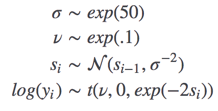

In [2]:
from pandas_datareader import data

In [3]:
import pandas as pd

returns = data.get_data_yahoo('SPY', start='2008-5-1', end='2009-12-1')['Close'].pct_change()

len(returns)

402

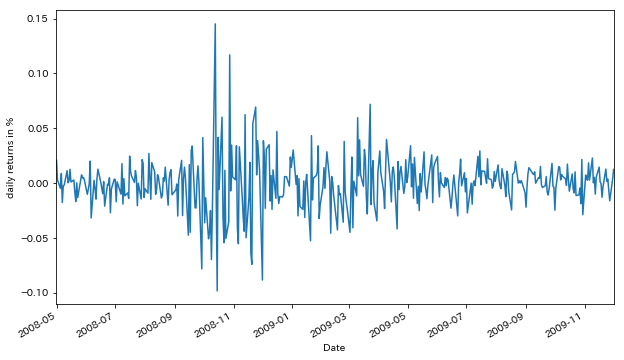

In [11]:
returns.plot(figsize=(10,6))
plt.ylabel('daily returns in %');

In [14]:
with pm.Model() as sp500_model:
    nu = pm.Exponential('nu', 1./10, testval=5.)
    sigma = pm.Exponential('sigma', 1./.02, testval=.1)

    s = pm.GaussianRandomWalk('s', sigma**-2, shape=len(returns))
    volatility_process = pm.Deterministic('volatility_process', pm.math.exp(-2*s))

    r = pm.StudentT('r', nu, lam=1/volatility_process, observed=returns)

In [15]:
with sp500_model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/stoba/anaconda/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|██████████| 2500/2500 [02:16<00:00, 18.27it/s]


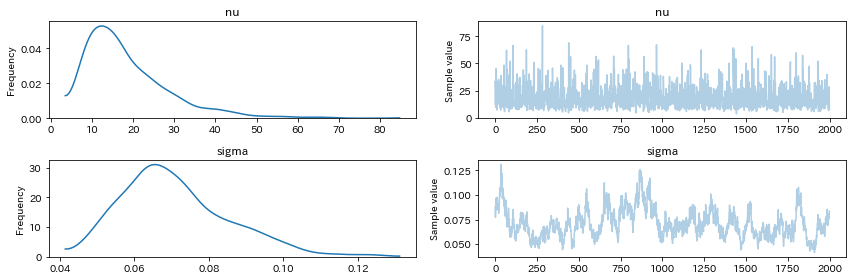

In [16]:
pm.traceplot(trace, [nu, sigma]);

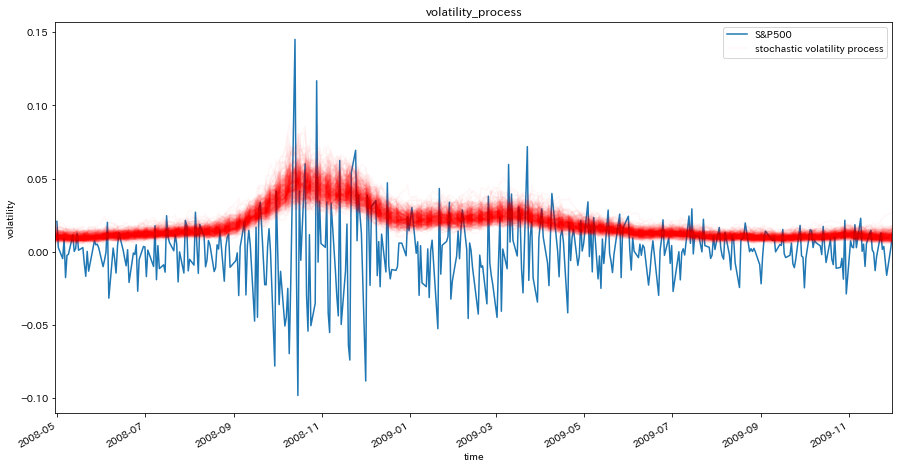

In [17]:
fig, ax = plt.subplots(figsize=(15, 8))
returns.plot(ax=ax)
ax.plot(returns.index, 1/np.exp(trace['s',::5].T), 'r', alpha=.03);
ax.set(title='volatility_process', xlabel='time', ylabel='volatility');
ax.legend(['S&P500', 'stochastic volatility process'])

## Case study 2: Coal mining disasters

Text(0.5,0,'Year')

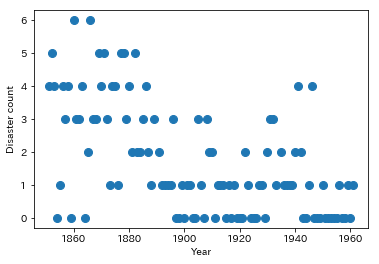

In [18]:
disaster_data = np.ma.masked_values([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                            3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                            2, 2, 3, 4, 2, 1, 3, -999, 2, 1, 1, 1, 1, 3, 0, 0,
                            1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                            0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                            3, 3, 1, -999, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                            0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1], value=-999)
year = np.arange(1851, 1962)

plt.plot(year, disaster_data, 'o', markersize=8);
plt.ylabel("Disaster count")
plt.xlabel("Year")

model information

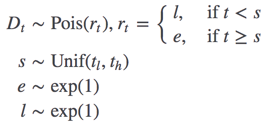

In [19]:
with pm.Model() as disaster_model:

    switchpoint = pm.DiscreteUniform('switchpoint', lower=year.min(), upper=year.max(), testval=1900)

    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential('early_rate', 1)
    late_rate = pm.Exponential('late_rate', 1)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= year, early_rate, late_rate)

    disasters = pm.Poisson('disasters', rate, observed=disaster_data)

In [20]:
with disaster_model:
    trace = pm.sample(10000)

Assigned Metropolis to switchpoint
Assigned NUTS to early_rate_log__
Assigned NUTS to late_rate_log__
Assigned Metropolis to disasters_missing
/Users/stoba/anaconda/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|██████████| 10500/10500 [00:11<00:00, 951.79it/s]


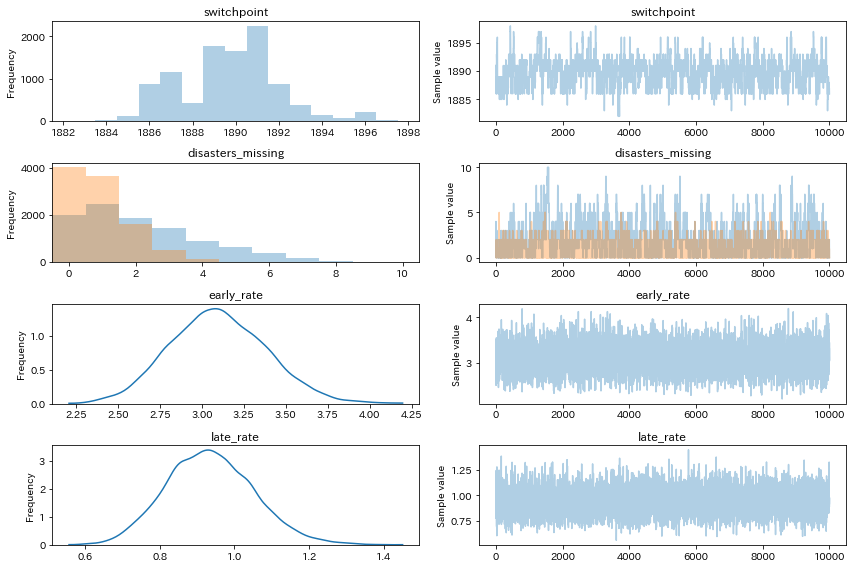

In [21]:
pm.traceplot(trace);

## Arbitrary deterministics

In [22]:
import theano.tensor as tt
from theano.compile.ops import as_op

@as_op(itypes=[tt.lscalar], otypes=[tt.lscalar])
def crazy_modulo3(value):
    if value > 0:
        return value % 3
    else :
        return (-value + 1) % 3

with pm.Model() as model_deterministic:
    a = pm.Poisson('a', 1)
    b = crazy_modulo3(a)

## Arbitrary distributions

In [24]:
class Beta(pm.Continuous):
    def __init__(self, mu, *args, **kwargs):
        super(Beta, self).__init__(*args, **kwargs)
        self.mu = mu
        self.mode = mu

    def logp(self, value):
        mu = self.mu
        return beta_logp(value - mu)


def beta_logp(value):
    return -1.5 * np.log(1 + (value)**2)


with pm.Model() as model:
    beta = Beta('slope', mu=0, testval=0)

## Generalized Linear Models

In [25]:
# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

# Convert X and Y to a pandas DataFrame
df = pd.DataFrame({'x1': X1, 'x2': X2, 'y': Y})

In [27]:
from pymc3.glm import GLM

with pm.Model() as model_glm:
    GLM.from_formula('y ~ x1 + x2', df)
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/stoba/anaconda/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|██████████| 1000/1000 [00:01<00:00, 887.31it/s]


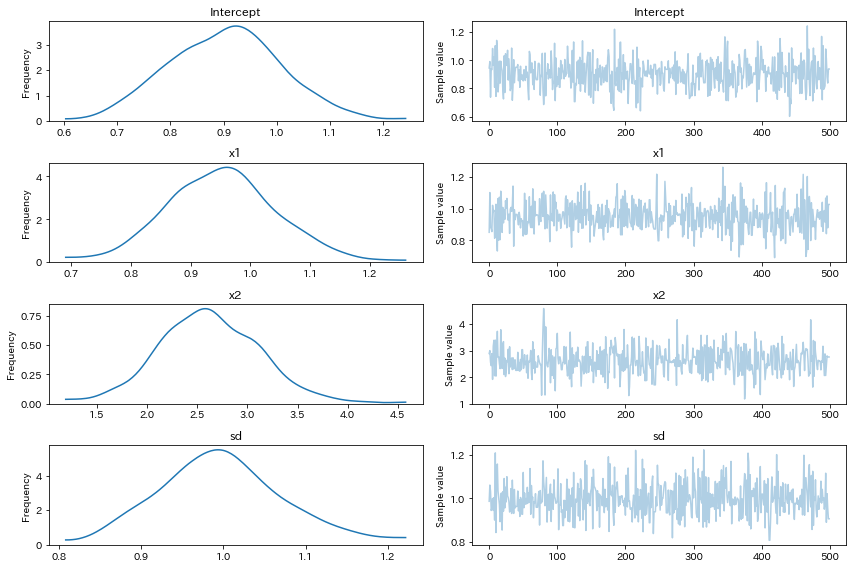

In [29]:
pm.traceplot(trace);

In [31]:
from pymc3.glm.families import Binomial

df_logistic = pd.DataFrame({'x1': X1, 'y': Y > np.median(Y)})

with pm.Model() as model_glm_logistic:
    GLM.from_formula('y ~ x1', df_logistic, family=Binomial())
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/stoba/anaconda/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|██████████| 1000/1000 [00:00<00:00, 1286.54it/s]


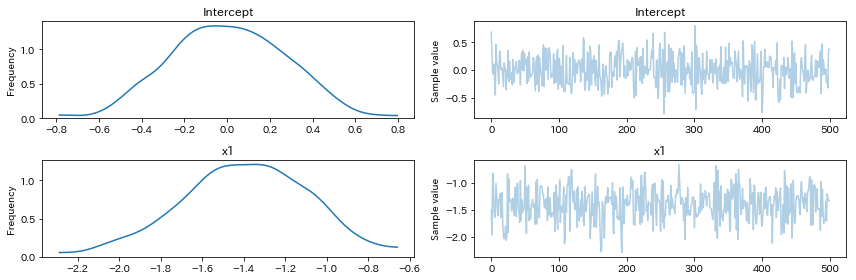

In [32]:
pm.traceplot(trace);